## TODO:
 - Pipeline
 - Transfer Learning?
 - Show samples that model got wrong
 - Other success metrics
 - General refactor

In [1]:
import numpy as np
np.random.seed(2020)

import os
import tqdm
import cv2
import pandas as pd
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

## Load Images

In [2]:
def load_images(dir_path, image_list, label_list, label):
    for img in os.listdir(dir_path):
        if img.endswith('.png'):
            image = cv2.imread(dir_path + img)
            image_list.append(image)
            label_list.append(label)

In [3]:
def get_img_shapes(images):
        shapes = [list(np.array(image).shape) for image in images]
        width = [shape[0] for shape in shapes]
        height = [shape[1] for shape in shapes]
   
        return (width, height)

In [4]:
def load_data():
    parasitized = './cell_images/Parasitized/'
    uninfected = './cell_images/Uninfected/'
    
    images = []
    labels = []
    
    load_images(uninfected, images, labels, 0)
    load_images(parasitized, images, labels, 1)
    width, height = get_img_shapes(images)
    
    median_height = np.median(height).astype('int64')
    median_width = np.median(width).astype('int64')
    median_shape = (median_width, median_height)
    
    for idx, image in enumerate(images):
        images[idx] = np.array(Image.fromarray(image, 'RGB').resize(median_shape))
    
    X = np.array(images)
    y = np.array(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
    
    if y_train.ndim == 1: y_train = to_categorical(y_train)
    if y_test.ndim == 1: y_test = to_categorical(y_test)
        
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()

# Visualisation

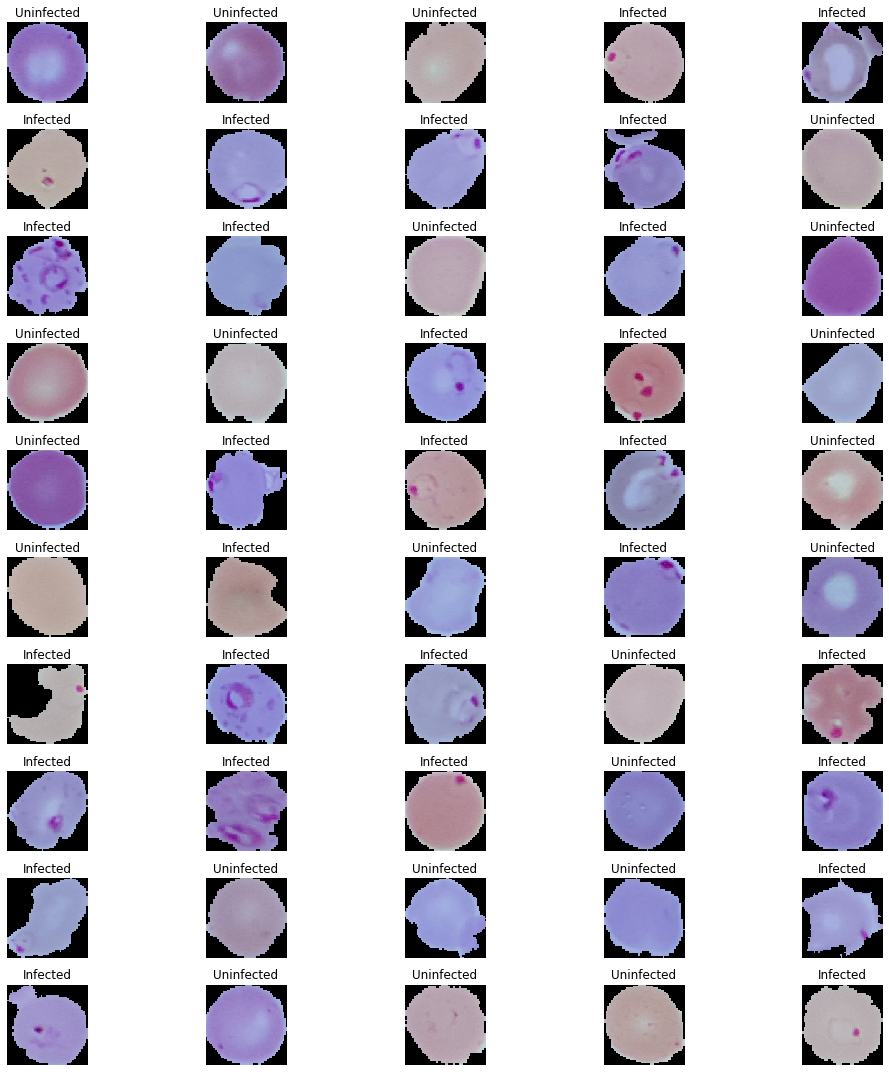

In [5]:
plt.figure(figsize=(15, 15))
for i in range(50):
    random = np.random.randint(0, len(X_train))
    plt.subplot(10, 5, i+1)
    plt.imshow(X_train[random])
    plt.title('Infected' if y_train[random][1] == 1 else 'Uninfected')
    plt.axis('off')
    
plt.tight_layout()

## Simple CNN

In [6]:
input_shape = X_train[0].shape

In [7]:
input_shape

(130, 130, 3)

In [8]:
results = []

In [9]:
basic_model = Sequential([
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
basic_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 15)      420       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 15)        2040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 15)        2040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________

In [10]:
results.append(('Basic model', basic_model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=(X_test, y_test))))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 19290 samples, validate on 8268 samples
Epoch 1/10
19290/19290 [==============================] - 145s 8ms/sample - loss: 7.6569 - acc: 0.5021 - val_loss: 7.7446 - val_acc: 0.4950
Epoch 2/10
19290/19290 [==============================] - 139s 7ms/sample - loss: 7.6569 - acc: 0.5021 - val_loss: 7.7446 - val_acc: 0.4950
Epoch 3/10
19290/19290 [==============================] - 176s 9ms/sample - loss: 7.6569 - acc: 0.5021 - val_loss: 7.7446 - val_acc: 0.4950
Epoch 4/10
19290/19290 [==============================] - 141s 7ms/sample - loss: 7.6569 - acc: 0.5021 - val_loss: 7.7446 - val_acc: 0.4950
Epoch 5/10
19290/19290 [==============================] - 134s 7ms/sample - loss: 7.6569 - acc: 0.5021 - val_loss: 7.7446 - val_acc: 0.4950
Epoch 6/10
19290/19290 [==============================] - 133s 7ms/sample - loss: 7.6569 - acc: 0.5021 - val_loss: 7.7446 - val_acc: 0.4950
Epoch 7/10
19290/

## Adding dropout on fully connected layers

In [12]:
dropout_model = Sequential([
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 15)      420       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 15)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 15)        2040      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 15)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 15)        2040      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 15)       

In [14]:
results.append(('Basic model with dropout', dropout_model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=(X_test, y_test))))

Train on 19290 samples, validate on 8268 samples
Epoch 1/10
19290/19290 [==============================] - 116s 6ms/sample - loss: 3.5272 - acc: 0.5052 - val_loss: 0.6925 - val_acc: 0.5260
Epoch 2/10
19290/19290 [==============================] - 110s 6ms/sample - loss: 0.7056 - acc: 0.5237 - val_loss: 0.6862 - val_acc: 0.5657
Epoch 3/10
19290/19290 [==============================] - 110s 6ms/sample - loss: 0.6845 - acc: 0.5566 - val_loss: 0.6672 - val_acc: 0.6017
Epoch 4/10
19290/19290 [==============================] - 111s 6ms/sample - loss: 0.6525 - acc: 0.6131 - val_loss: 0.6406 - val_acc: 0.6217
Epoch 5/10
19290/19290 [==============================] - 111s 6ms/sample - loss: 0.6748 - acc: 0.5843 - val_loss: 0.6193 - val_acc: 0.6993
Epoch 6/10
19290/19290 [==============================] - 111s 6ms/sample - loss: 0.6188 - acc: 0.6685 - val_loss: 0.6161 - val_acc: 0.7157
Epoch 7/10
19290/19290 [==============================] - 110s 6ms/sample - loss: 0.5520 - acc: 0.7277 - val_lo

In [15]:
bn_model = Sequential([
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
bn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 15)      420       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 15)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 62, 62, 15)        2040      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 15)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 15)        2040      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 15)       

In [17]:
results.append(('Dropout + BatchNorm', bn_model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=(X_test, y_test))))

Train on 19290 samples, validate on 8268 samples
Epoch 1/10
19290/19290 [==============================] - 109s 6ms/sample - loss: 0.1275 - acc: 0.9554 - val_loss: 0.1725 - val_acc: 0.9425
Epoch 2/10
19290/19290 [==============================] - 113s 6ms/sample - loss: 0.1205 - acc: 0.9573 - val_loss: 0.1790 - val_acc: 0.9399
Epoch 3/10
19290/19290 [==============================] - 112s 6ms/sample - loss: 0.1177 - acc: 0.9585 - val_loss: 0.1982 - val_acc: 0.9299
Epoch 4/10
19290/19290 [==============================] - 112s 6ms/sample - loss: 0.1098 - acc: 0.9616 - val_loss: 0.1655 - val_acc: 0.9448
Epoch 5/10
19290/19290 [==============================] - 111s 6ms/sample - loss: 0.1059 - acc: 0.9616 - val_loss: 0.1864 - val_acc: 0.9382
Epoch 6/10
19290/19290 [==============================] - 112s 6ms/sample - loss: 0.0993 - acc: 0.9638 - val_loss: 0.1928 - val_acc: 0.9320
Epoch 7/10
19290/19290 [==============================] - 111s 6ms/sample - loss: 0.0951 - acc: 0.9667 - val_lo

## Testing double Conv layers

In [18]:
double_cl_model = Sequential([
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=9, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=9, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=9, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters=15, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=9, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
double_cl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
double_cl_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 15)      420       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 126, 126, 9)       1224      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 9)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 15)        1230      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 59, 59, 9)         1224      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 29, 29, 9)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 27, 27, 15)       

In [20]:
results.append(('Dobled convolution layers', double_cl_model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=(X_test, y_test))))

Train on 19290 samples, validate on 8268 samples
Epoch 1/10
19290/19290 [==============================] - 146s 8ms/sample - loss: 0.6958 - acc: 0.5572 - val_loss: 0.6357 - val_acc: 0.7286
Epoch 2/10
19290/19290 [==============================] - 147s 8ms/sample - loss: 0.4714 - acc: 0.7940 - val_loss: 0.2675 - val_acc: 0.8962
Epoch 3/10
19290/19290 [==============================] - 147s 8ms/sample - loss: 0.2012 - acc: 0.9345 - val_loss: 0.1595 - val_acc: 0.9486
Epoch 4/10
19290/19290 [==============================] - 148s 8ms/sample - loss: 0.1622 - acc: 0.9502 - val_loss: 0.1472 - val_acc: 0.9534
Epoch 5/10
19290/19290 [==============================] - 151s 8ms/sample - loss: 0.1512 - acc: 0.9524 - val_loss: 0.1488 - val_acc: 0.9517
Epoch 6/10
19290/19290 [==============================] - 151s 8ms/sample - loss: 0.1419 - acc: 0.9540 - val_loss: 0.1411 - val_acc: 0.9539
Epoch 7/10
19290/19290 [==============================] - 150s 8ms/sample - loss: 0.1375 - acc: 0.9543 - val_lo

## Data augmentation

In [ ]:
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True
# )

In [ ]:
#datagen.fit(X_train)

In [ ]:
#double_cl_model.fit_generator(datagen.flow(X_train, y_train, batch_size=1024), steps_per_epoch=len(X_train)/1024, epochs=10)

In [ ]:
#double_cl_model.evaluate(X_test, y_test)

## All models in comparison (without data augmentation)

In [31]:
def plot_loss(history, key='acc'):
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.xlabel('Epochs')
    plt.ylabel(key.title())
    plt.legend(['train', 'test'], loc='best')

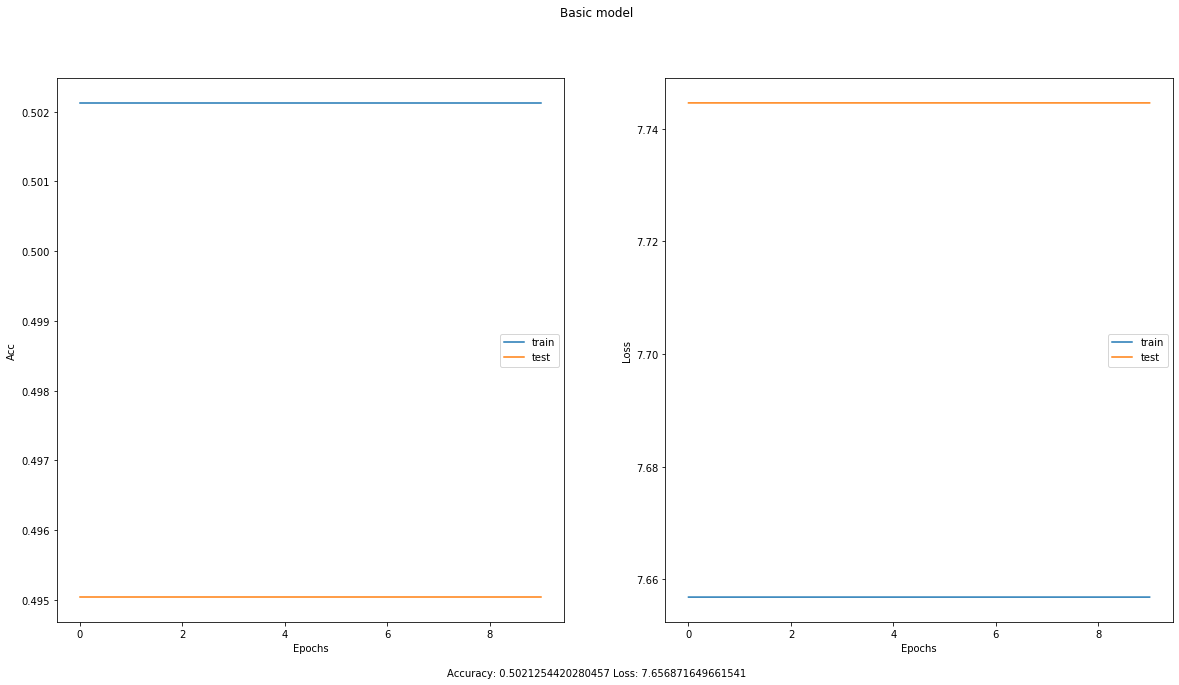

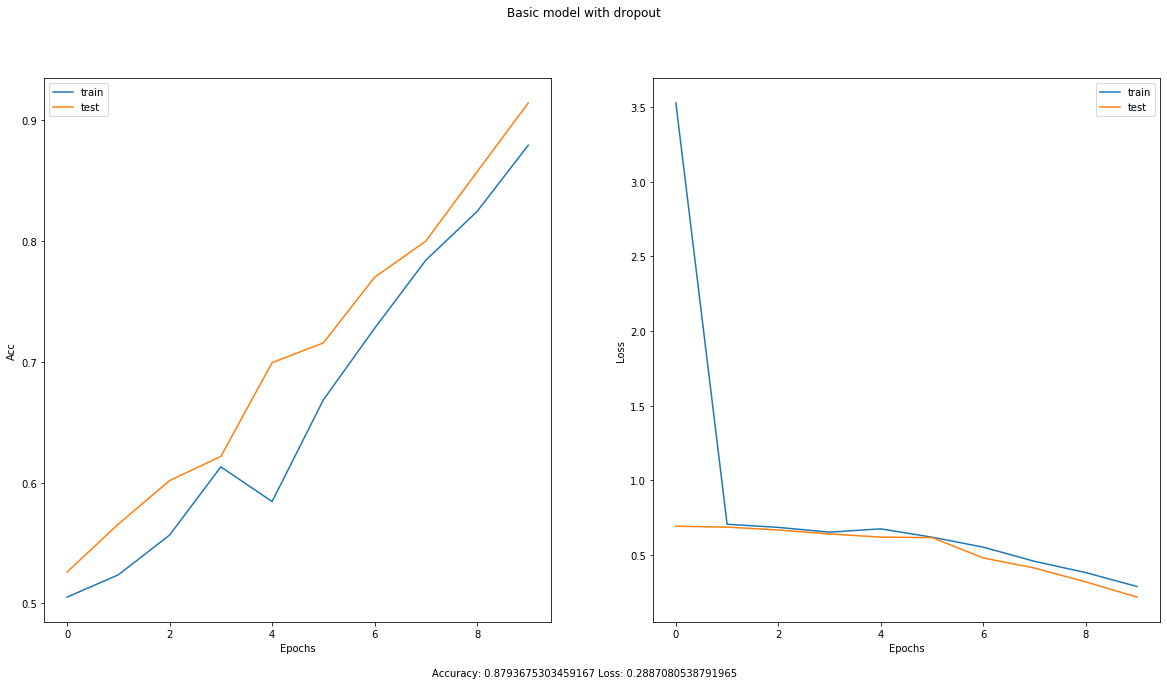

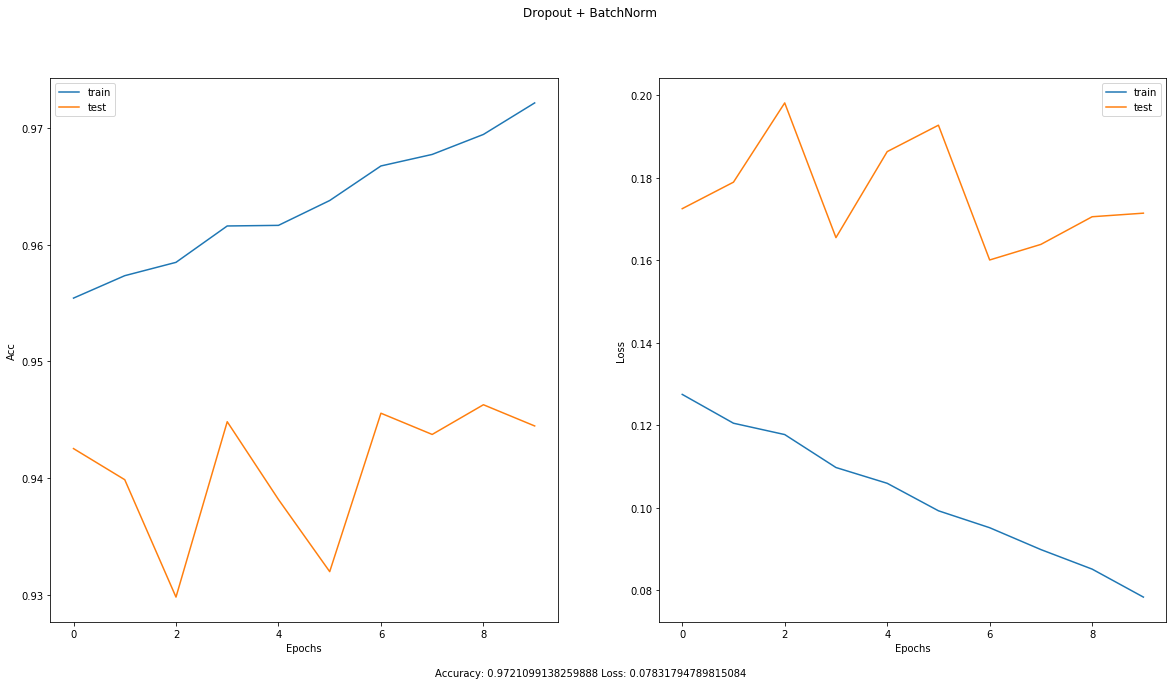

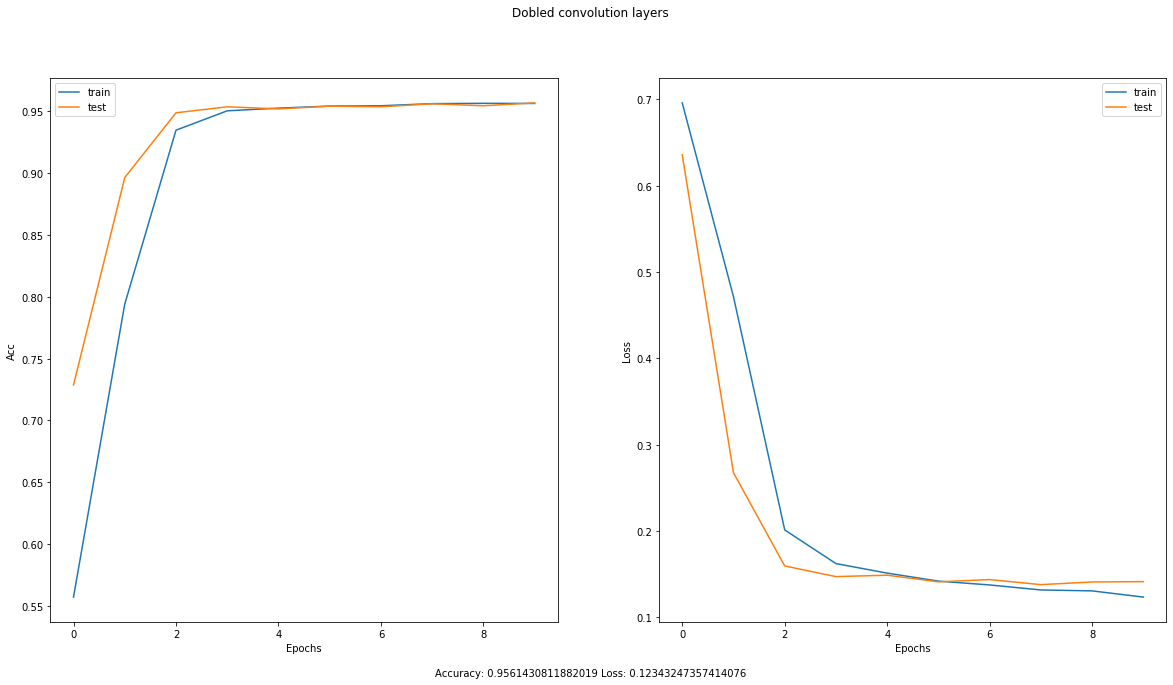

In [60]:
for name, result in results:
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle(name)
    fig.text(.5, .05, 'Accuracy: {0} Loss: {1}'.format(result.history['acc'][-1], result.history['loss'][-1]), ha='center')
    plt.subplot(121)
    plot_loss(result)
    plt.subplot(122)
    plot_loss(result, key='loss')
    
plt.show()